# BLE Proximity Experiment - Linear Regression
## Experiment based on the measurements of the BLE RSSI values according to the distance to the BLE Estimote beacon

### Imports
Imports of required libraries

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

<Figure size 432x288 with 0 Axes>

### Load File
Function that allows to load a file from disk

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

### Initialize Dataset
Initialization of the data from the file

In [3]:
dataset = load_file('../../distance_proximity_experiments.csv')
positions = dataset['coordinate_Y']
dataset['distance'] = positions
#distance_proximity_experiments were made with purple beacon
display(dataset)
display(dataset.shape)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-50,-50.000000,0-1 meters,0.0
1,0.0,0.0,-50,-50.000000,0-1 meters,0.0
2,0.0,0.0,-53,-51.000000,0-1 meters,0.0
3,0.0,0.0,-51,-51.000000,0-1 meters,0.0
4,0.0,0.0,-53,-53.000000,0-1 meters,0.0
...,...,...,...,...,...,...
456,0.0,4.0,-83,-84.250000,3-4 meters,4.0
457,0.0,4.0,-86,-84.600000,3-4 meters,4.0
458,0.0,4.0,-87,-85.000000,3-4 meters,4.0
459,0.0,4.0,-86,-85.142857,3-4 meters,4.0


(461, 6)

### File Overall Description
Usage of describe pandas function on the dataset

In [4]:
display(dataset.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
coordinate_X,461.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0
coordinate_Y,461.0,1.973970,1.274489,0.0,1.0,2.00,3.0,4.0
rssi_Value,461.0,-78.206074,9.461756,-94.0,-85.0,-81.00,-75.0,-50.0
rolling_mean_rssi,461.0,-78.065939,9.240107,-91.0,-84.0,-81.25,-76.0,-50.0
distance,461.0,1.973970,1.274489,0.0,1.0,2.00,3.0,4.0


### Scanned Distances
Graphical display of the distances beacon/smartphone scanned in the experiment

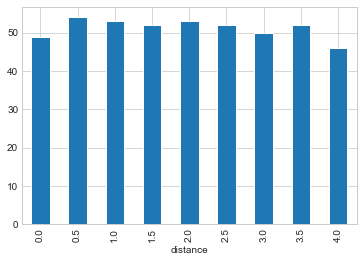

In [5]:
distances = dataset['distance']
reference_points = dataset.groupby(['distance'])
reference_points.size().plot(kind="bar")

### Beacon RSSI Display
Graphical display of the rssi values recorded at each position

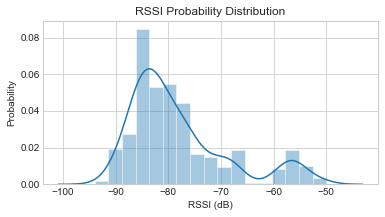

In [6]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

sns.distplot(dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Beacon Rolling Mean RSSI Display
Graphical adisplay of the rolling mean value recorded at each position

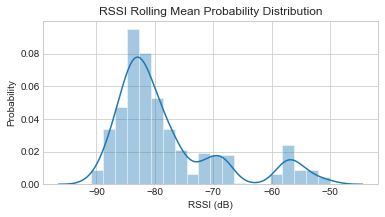

In [7]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Graphical Display of RSSI/Rolling Mean Distribution
Graphical display of the previous measures - rssi and rolling mean

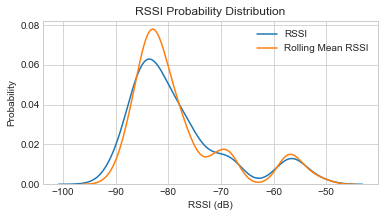

In [8]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Initialize Training Data
Training Data intialization for predictions purposes

In [9]:
train_X_rssi = pd.DataFrame(dataset['rssi_Value']).values.reshape(-1,1)
train_X_rolling_mean = pd.DataFrame(dataset['rolling_mean_rssi']).values.reshape(-1,1)
train_Y = pd.DataFrame(dataset['distance']).values.reshape(-1,1)
default_groups = dataset['distance'].map(str)
data_plot_means = dataset.groupby(['distance'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)
scaler = [StandardScaler(),MinMaxScaler(),MaxAbsScaler(),None]

,rssi_Value,rolling_mean_rssi
distance,,
0.0,-56.142857,-55.970408
0.5,-69.648148,-69.613316
1.0,-80.830189,-81.069969
1.5,-78.211538,-78.589148
2.0,-81.660377,-81.347469
2.5,-82.692308,-82.339034
3.0,-85.580000,-85.826857
3.5,-82.903846,-82.107601
4.0,-86.347826,-85.856548


### Plot Training Data
Graphical Display of the observations in the dataset

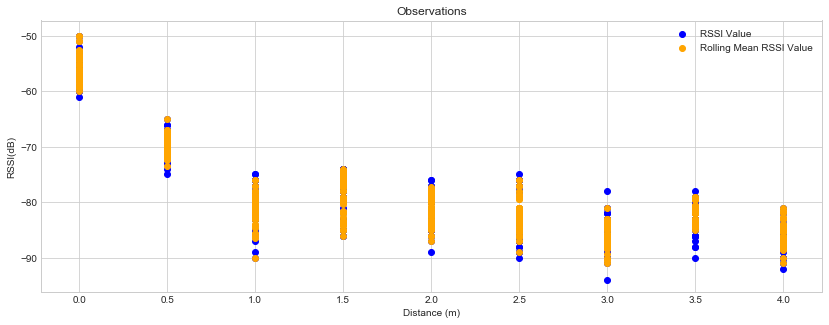

In [10]:
plt.figure(figsize=(14,5))
plt.scatter(dataset['distance'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['distance'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Distance (m)')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Statistics Output Format
Structure of the statistical output of each call to the machine learning algorithm

In [11]:
def structure_data(data,rsquared):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    std = data['error'].std()
    q25 = data['error'].quantile(q=0.25)
    q50= data['error'].quantile(q=0.5)
    q75 =data['error'].quantile(q=0.7)
    q95= data['error'].quantile(q=0.95)
    r_squared = rsquared
    minValue= data['error'].min()
    maxValue = data['error'].max()
    statistical_results = [mae,mse,rsme,std,q25,q50,q75,q95,minValue,maxValue,r_squared]
    return statistical_results

### Liner Regression Experiments
Experiments with linear regression algorithm

In [12]:
def compute_Linear_Regression(flag=0,colors=None,trainX_data = None, trainY_data = None,testX_data = None,testY_data = None, scaler = None,
                            cross_validation = None):
    # Init the Linear Regressor Estimator
    linear_regression_estimator = LinearRegression()
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,linear_regression_estimator)
    else:
        main_estimator = linear_regression_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    else:
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation,groups=default_groups)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    statistical_array = list()
    error_dataframe = pd.DataFrame({'Actual': testY_data.flatten(), 'Predicted':predict_test.flatten()})
    if flag == 1:
        display(error_dataframe)
        df1 = error_dataframe.head(25)
        df1.plot(kind='bar',figsize=(12,6))
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
        plt.show()
        plt.figure(figsize=(18,10))
        plt.scatter(dataset['distance'],dataset['rssi_Value'],label='RSSI Value',color='blue')
        plt.scatter(dataset['distance'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
        plt.xlim(testY_data.min()-1, testY_data.max()+1)
        plt.ylim(testX_data.min()-1, testX_data.max()+1)
        plt.xticks(np.arange(testY_data.min(), testY_data.max()+1, 1.0))
        plt.yticks(np.arange(testX_data.min(), testX_data.max()+1, 2.0))
        if colors is not None:
            plt.plot(predict_test, testX_data, color=colors,label='Linear Regression')
        else:
            plt.plot(predict_test, testX_data, color='red', label='Linear Regression')
        # Show and place the legent
        plt.legend(loc='upper right')
        plt.show()
    observed_errors = error_dataframe['Predicted'] - error_dataframe['Actual']
    error = pd.DataFrame(observed_errors, columns=["error"])
    result = pd.DataFrame(train_Y,columns=["distance"]).join(error)
    return structure_data(result,coefficient_determination)


#### 1st Experiment - Check Overfitting scenario (Without Testing Data) Using RSSI
Use Linear Regression to check the results on the training data alone

,Actual,Predicted
0,0.0,-0.982821
1,0.0,-0.982821
2,0.0,-0.668337
3,0.0,-0.877993
4,0.0,-0.668337
...,...,...
456,4.0,2.476508
457,4.0,2.790993
458,4.0,2.895821
459,4.0,2.790993


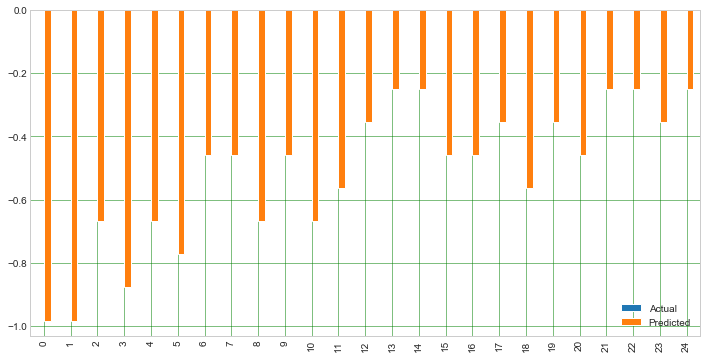

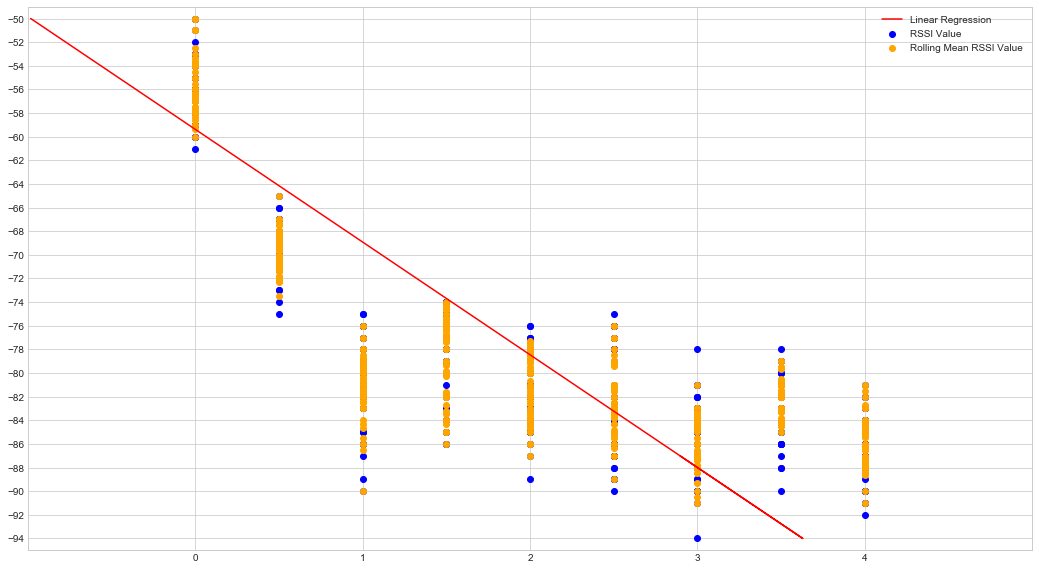

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.661573,0.639148,0.799467,0.800336,-0.652461,0.06546,0.404086,1.266852,-1.733148,2.210305,0.605658


In [13]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
result = compute_Linear_Regression(flag=1,trainX_data=train_X_rssi,trainY_data=train_Y,
                                   testX_data=train_X_rssi,testY_data=train_Y,
                                   scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

#### 2nd Experiment - Check Overfitting scenario (Without Testing Data) Using Rolling Mean
Use Linear Regression to check the results on the training data alone

,Actual,Predicted
0,0.0,-1.033343
1,0.0,-1.033343
2,0.0,-0.926191
3,0.0,-0.926191
4,0.0,-0.711888
...,...,...
456,4.0,2.636602
457,4.0,2.674105
458,4.0,2.716966
459,4.0,2.732273


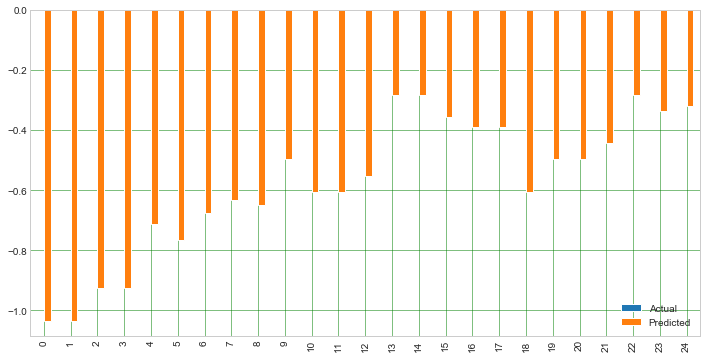

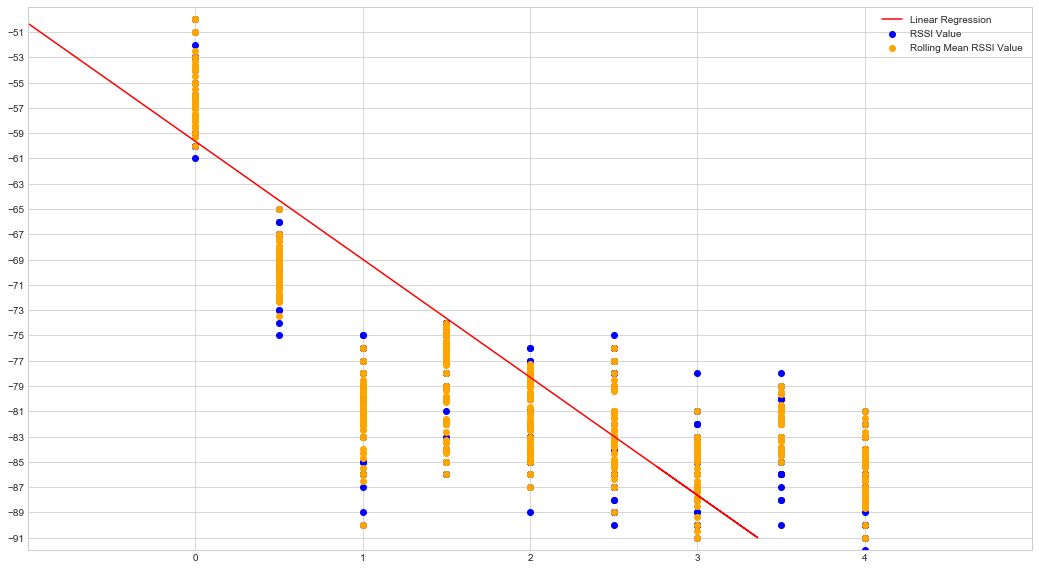

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.65333,0.64264,0.801648,0.802519,-0.604736,0.038297,0.431228,1.324076,-1.711641,2.252724,0.603504


In [14]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
result = compute_Linear_Regression(flag=1,trainX_data=train_X_rolling_mean,trainY_data=train_Y,
                                   testX_data=train_X_rolling_mean,testY_data=train_Y,
                                   scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

#### 3rd Experiment - Linear Regression with StratifiedKFold (RSSI pure)
Experiment using cross validation approach of StratifiedKFold

,Actual,Predicted
0,0.0,-1.169760
1,0.0,-1.169760
2,0.0,-0.837351
3,0.0,-1.058957
4,0.0,-0.837351
...,...,...
456,4.0,2.469220
457,4.0,2.768933
458,4.0,2.868837
459,4.0,2.768933


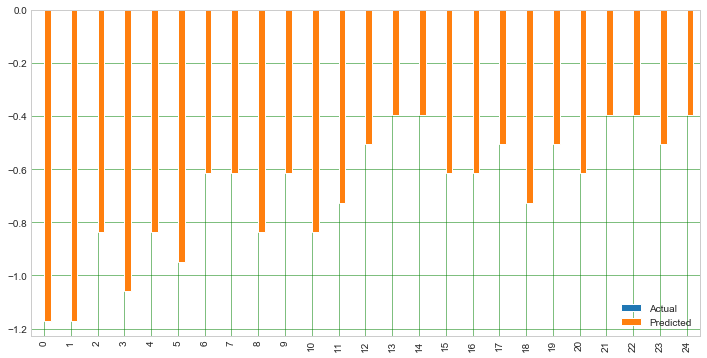

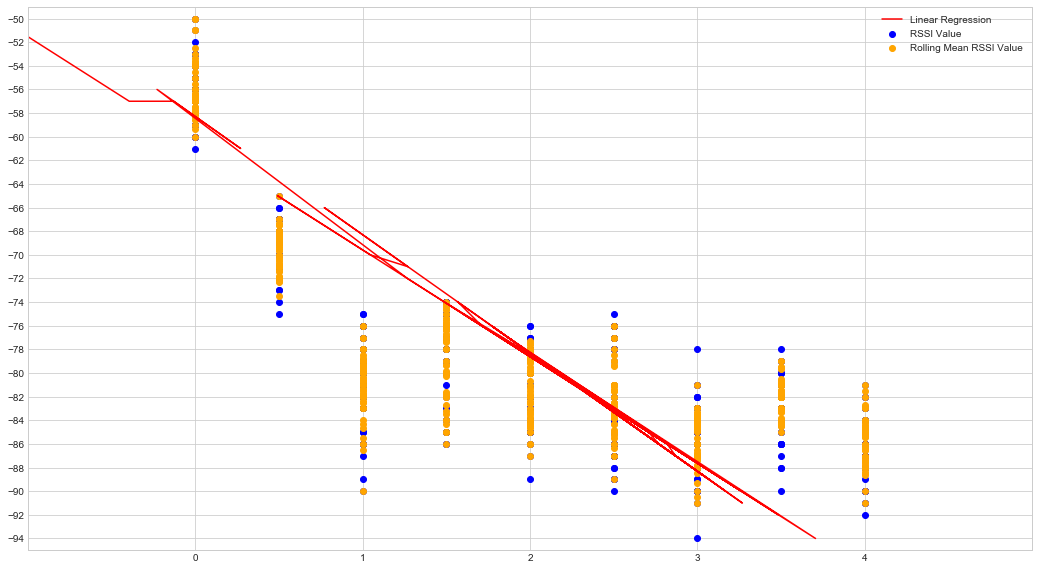

,Actual,Predicted
0,0.0,-1.136096
1,0.0,-1.136096
2,0.0,-0.806403
3,0.0,-1.026198
4,0.0,-0.806403
...,...,...
456,4.0,2.508162
457,4.0,2.819777
458,4.0,2.923649
459,4.0,2.819777


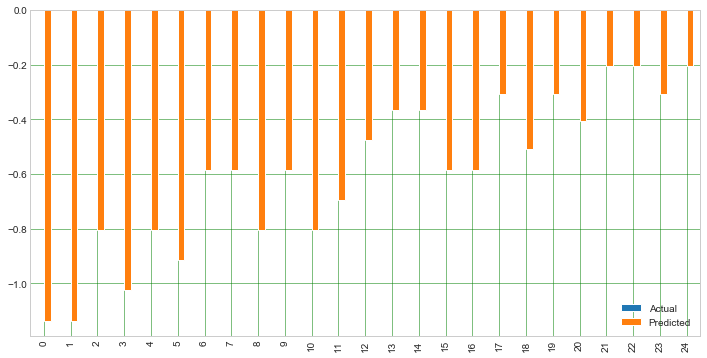

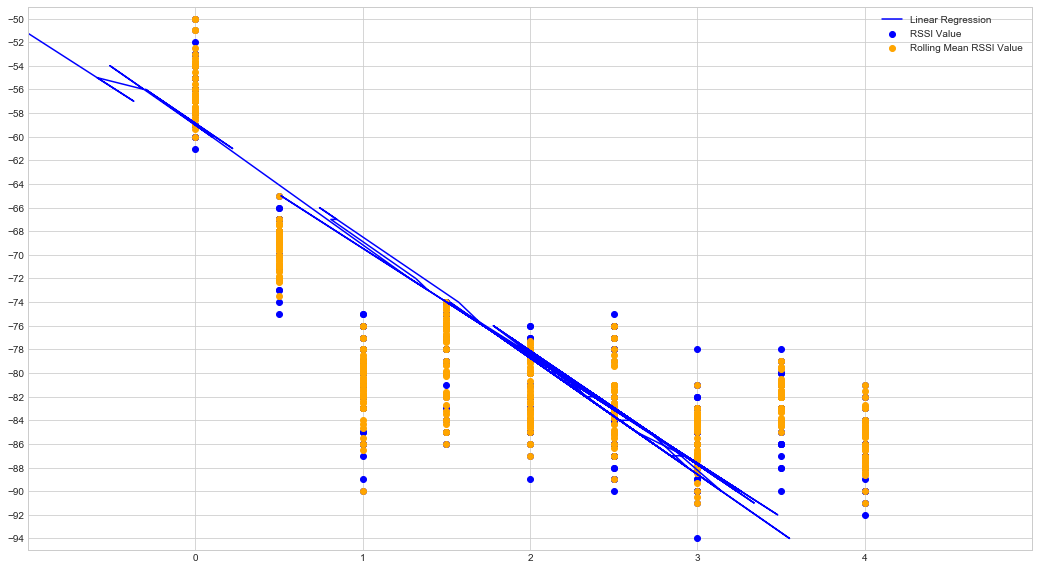

,Actual,Predicted
0,0.0,-1.140408
1,0.0,-1.140408
2,0.0,-0.809777
3,0.0,-1.030197
4,0.0,-0.809777
...,...,...
456,4.0,2.489417
457,4.0,2.798444
458,4.0,2.901453
459,4.0,2.798444


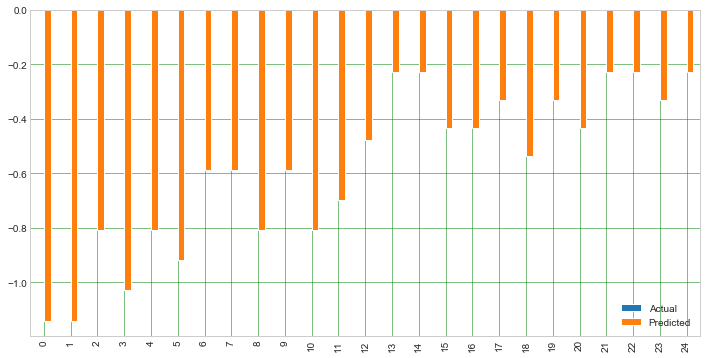

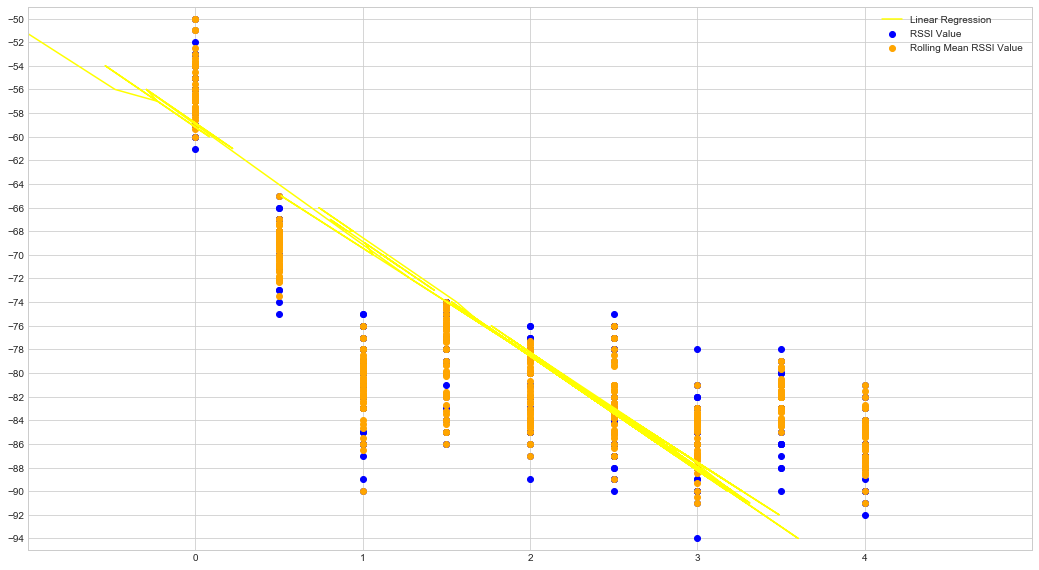

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,folds
2,0.663614,0.645885,0.803670,0.804543,-0.639319,0.061641,0.444284,1.283400,-1.748020,2.268006,0.601501,4
1,0.664789,0.648238,0.805132,0.806007,-0.630285,0.035676,0.450083,1.300418,-1.768792,2.259817,0.600050,3
0,0.666628,0.648037,0.805007,0.805879,-0.630205,0.069124,0.470657,1.269412,-1.730588,2.262368,0.600174,2


Number of Folds:  4


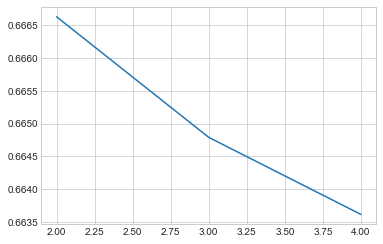

In [15]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
cross_validation_list = np.arange(2,5)
colors = ['red','blue','yellow']
counter = 0
results = list()
for cv in cross_validation_list:
    skf = StratifiedKFold(n_splits=cv)
    splited = skf.split(train_X_rssi,default_groups,default_groups)
    result = compute_Linear_Regression(flag = 1,colors=colors[counter],testX_data=train_X_rssi,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited)  
    result.append(cv)
    results.append(result)
    counter = counter + 1
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### 4th Experiment - Linear Regression with StratifiedKFold (Rolling Mean)
Experiment using cross validation approach of StratifiedKFold

,Actual,Predicted
0,0.0,-1.254152
1,0.0,-1.254152
2,0.0,-1.139284
3,0.0,-1.139284
4,0.0,-0.909549
...,...,...
456,4.0,2.600663
457,4.0,2.635936
458,4.0,2.676249
459,4.0,2.690646


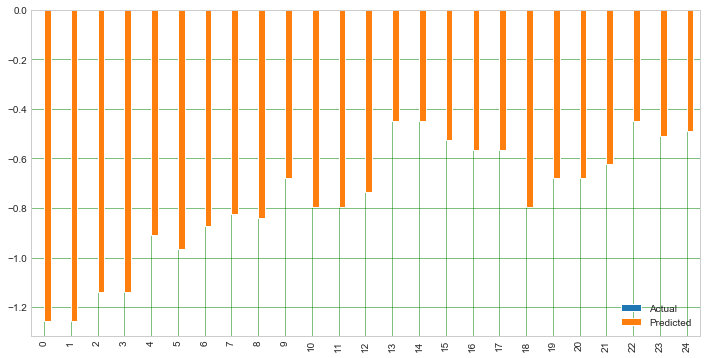

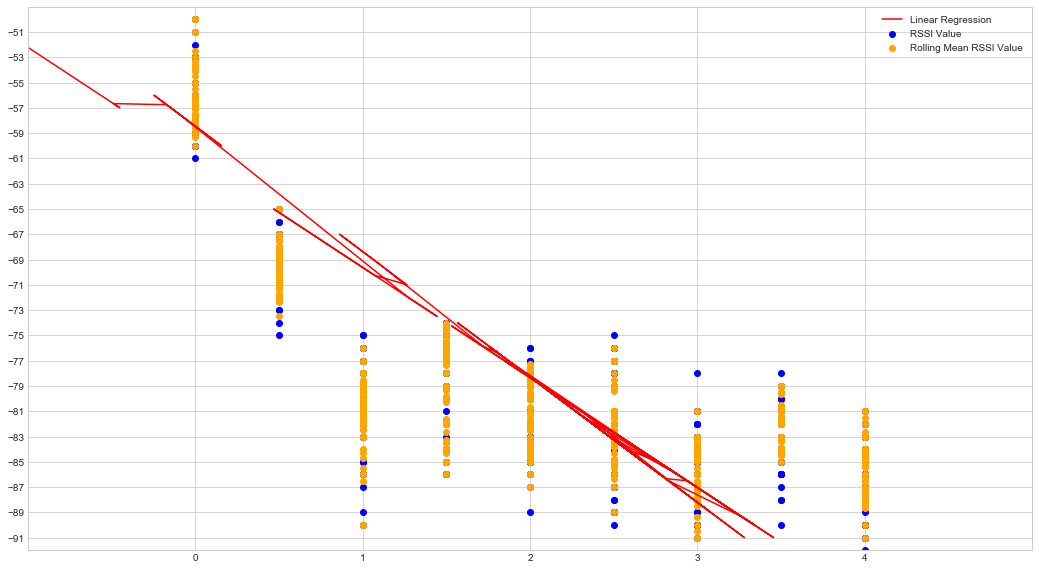

,Actual,Predicted
0,0.0,-1.201833
1,0.0,-1.201833
2,0.0,-1.088819
3,0.0,-1.088819
4,0.0,-0.862793
...,...,...
456,4.0,2.657562
457,4.0,2.694456
458,4.0,2.736620
459,4.0,2.751679


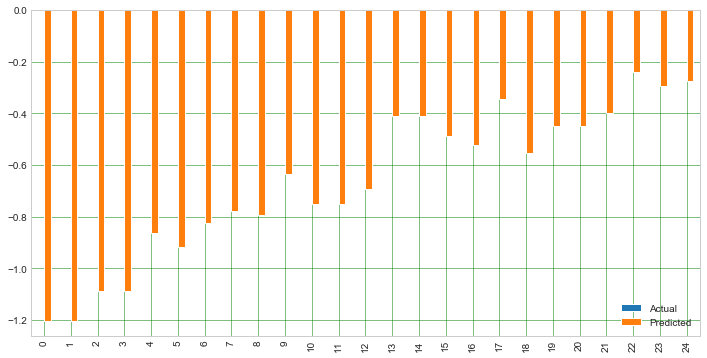

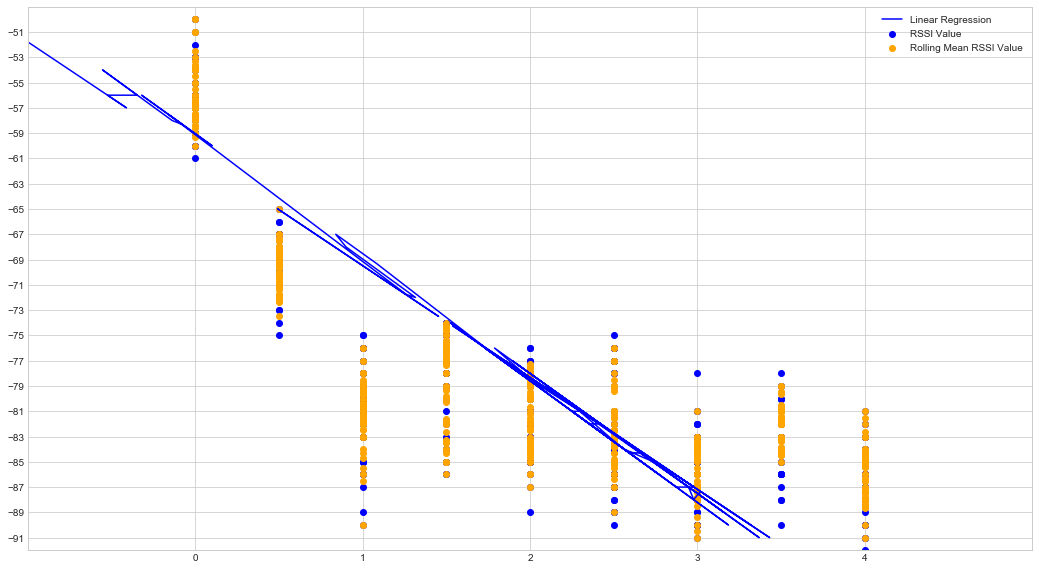

,Actual,Predicted
0,0.0,-1.222724
1,0.0,-1.222724
2,0.0,-1.108796
3,0.0,-1.108796
4,0.0,-0.880940
...,...,...
456,4.0,2.644710
457,4.0,2.681491
458,4.0,2.723527
459,4.0,2.738540


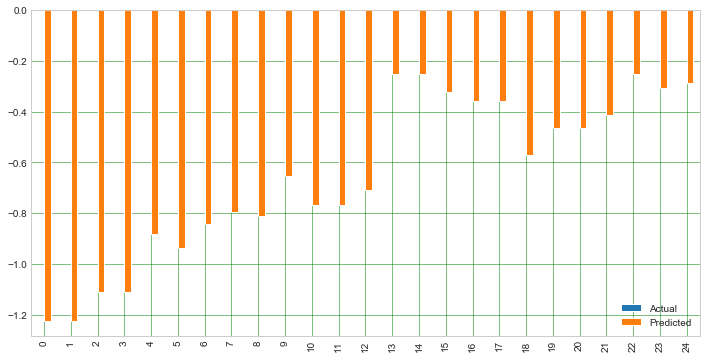

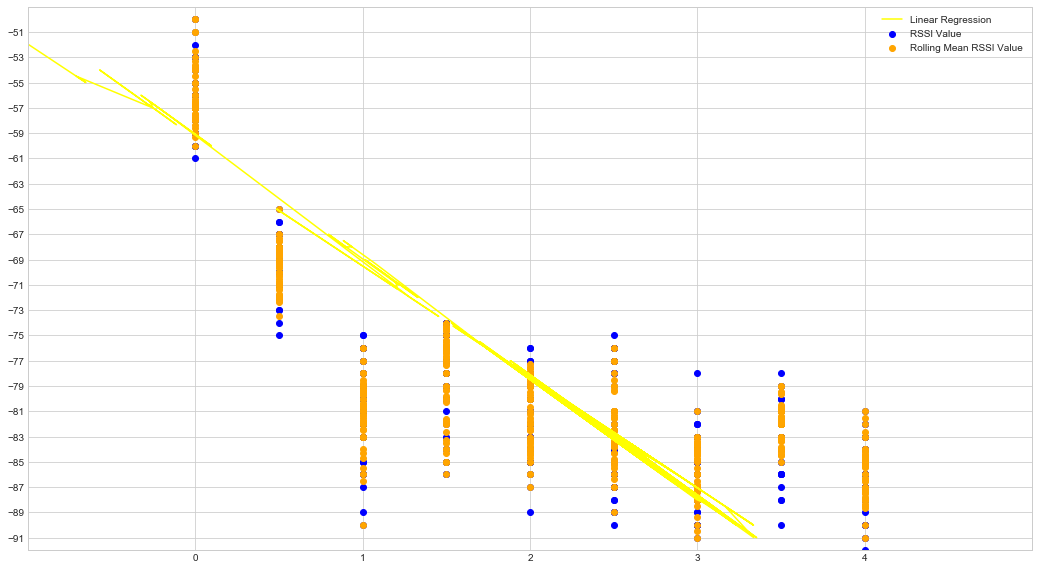

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,folds
2,0.655798,0.652470,0.807756,0.808634,-0.653084,0.026226,0.437003,1.333455,-1.736877,2.334396,0.597439,4
1,0.655951,0.652426,0.807729,0.808606,-0.636767,0.031078,0.462536,1.314977,-1.749278,2.318694,0.597466,3
0,0.657785,0.655403,0.809570,0.810449,-0.659453,0.015000,0.462981,1.306740,-1.726873,2.340547,0.595629,2


Number of Folds:  4


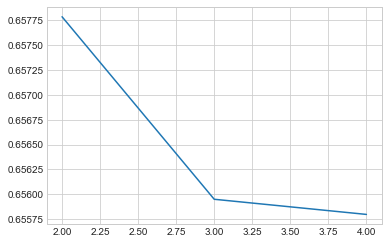

In [16]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
cross_validation_list = np.arange(2,5)
results = list()
colors = ['red','blue','yellow']
counter = 0
for cv in cross_validation_list:
    skf = StratifiedKFold(n_splits=cv)
    splited = skf.split(train_X_rolling_mean,default_groups)
    result = compute_Linear_Regression(flag = 1,colors=colors[counter],testX_data=train_X_rolling_mean,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited)  
    result.append(cv)
    results.append(result)
    counter = counter + 1
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### 5th Experiment - Linear Regression with HoldOut (RSSI pure)
Experiment using cross validation approach of HoldOut (Train test split)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,test_size
0,0.638669,0.587528,0.766504,0.774727,-0.437268,0.141701,0.498027,1.128285,-1.526711,1.473289,0.642318,0.1
2,0.641201,0.599235,0.774103,0.776519,-0.468001,0.085481,0.472646,1.200188,-1.518797,1.689760,0.632590,0.3
3,0.647544,0.600442,0.774882,0.776983,-0.546683,0.077364,0.469348,1.177364,-1.630652,1.681372,0.629754,0.4
4,0.649027,0.599148,0.774047,0.775698,-0.615316,0.064978,0.462388,1.161093,-1.640203,1.667568,0.628067,0.5
1,0.656554,0.605991,0.778454,0.782330,-0.497543,0.106995,0.530659,1.166154,-1.520232,1.688843,0.627768,0.2
5,0.664539,0.635079,0.796918,0.798121,-0.650200,0.054109,0.443335,1.174540,-1.650200,1.860574,0.608485,0.6
6,0.664183,0.639522,0.799701,0.800835,-0.644719,0.046545,0.443633,1.243534,-1.747631,2.178577,0.604923,0.7
8,0.664205,0.641645,0.801028,0.801633,-0.675890,0.036721,0.421765,1.249332,-1.750668,2.206081,0.602554,0.9
7,0.668810,0.646610,0.804121,0.805177,-0.639772,0.050000,0.446591,1.256819,-1.743181,2.187503,0.601070,0.8


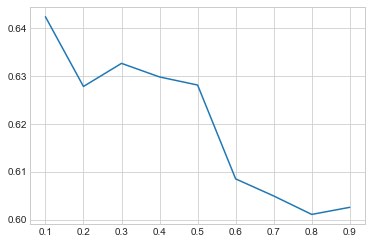

In [17]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(train_X_rssi,train_Y, test_size = size, random_state = 6,stratify=default_groups)
    result = compute_Linear_Regression(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['r-squared'],ascending=False))
plt.plot(statistics['test_size'],statistics['r-squared'])

#### 6th Experiment - Linear Regression with HoldOut (Rolling Mean)
Experiment using cross validation approach of HoldOut (Train test split)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,test_size
0,0.614878,0.573185,0.757090,0.765122,-0.413600,0.082594,0.434483,1.140576,-1.396232,1.215569,0.651050,0.1
1,0.633487,0.586002,0.765507,0.769638,-0.469564,-0.002067,0.477800,1.177608,-1.398998,1.389305,0.640046,0.2
3,0.625223,0.591312,0.768968,0.769928,-0.528350,-0.007473,0.392465,1.161289,-1.680497,1.653510,0.635384,0.4
2,0.631257,0.599754,0.774438,0.777079,-0.523961,0.004485,0.425132,1.210213,-1.510207,1.665629,0.632272,0.3
4,0.632299,0.594112,0.770786,0.772031,-0.542040,-0.007169,0.450295,1.161969,-1.682245,1.646638,0.631194,0.5
5,0.649061,0.626287,0.791383,0.792142,-0.552478,-0.026524,0.447522,1.193217,-1.689127,1.778038,0.613905,0.6
6,0.650636,0.636817,0.798008,0.798741,-0.544134,-0.018341,0.447269,1.230433,-1.742414,2.188538,0.606594,0.7
7,0.656619,0.647468,0.804654,0.805256,-0.579561,-0.013367,0.425899,1.260080,-1.739920,2.206626,0.600541,0.8
8,0.655311,0.644934,0.803078,0.803136,-0.658543,-0.006178,0.406287,1.267111,-1.743685,2.227934,0.600517,0.9


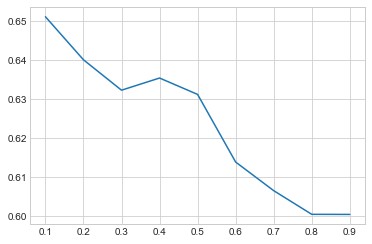

In [18]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(train_X_rolling_mean,train_Y, test_size = size, random_state = 6,stratify=default_groups)
    result = compute_Linear_Regression(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['r-squared'],ascending=False))
plt.plot(statistics['test_size'],statistics['r-squared'])

#### 7th Experiment - Linear Regression with LOGO (RSSI)
Experiment using cross validation approach of Leave One Group Out

In [19]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(train_X_rssi,train_Y,groups=default_groups)
loo = compute_Linear_Regression(testX_data=train_X_rssi,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.84244,0.968908,0.984331,0.982058,-1.029995,0.089611,0.566044,1.449902,-1.98136,2.45306,0.402203


#### 8th Experiment - Linear Regression with LOGO (Rolling Mean)
Experiment using cross validation approach of Leave One Group Out

In [20]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(train_X_rolling_mean,train_Y,groups=default_groups)
loo = compute_Linear_Regression(testX_data=train_X_rolling_mean,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.864764,1.067494,1.033196,1.028675,-1.171442,0.020014,0.559494,1.480551,-2.350234,2.509507,0.341377


#### 9th Experiment - Best cross-validation technique
Best parameters found using Linear Regression

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,method,type
4,0.631257,0.599754,0.774438,0.777079,-0.523961,0.004485,0.425132,1.210213,-1.510207,1.665629,0.632272,HoldOut,Rolling Mean RSSI
1,0.641201,0.599235,0.774103,0.776519,-0.468001,0.085481,0.472646,1.200188,-1.518797,1.689760,0.632590,HoldOut,RSSI Only
5,0.655798,0.652470,0.807756,0.808634,-0.653084,0.026226,0.437003,1.333455,-1.736877,2.334396,0.597439,Stratified K-Fold,Rolling Mean RSSI
2,0.663614,0.645885,0.803670,0.804543,-0.639319,0.061641,0.444284,1.283400,-1.748020,2.268006,0.601501,Stratified K-Fold,RSSI Only
0,0.842440,0.968908,0.984331,0.982058,-1.029995,0.089611,0.566044,1.449902,-1.981360,2.453060,0.402203,LOO,RSSI Only
3,0.864764,1.067494,1.033196,1.028675,-1.171442,0.020014,0.559494,1.480551,-2.350234,2.509507,0.341377,LOO,Rolling Mean RSSI


Selected cross validation method:  HoldOut


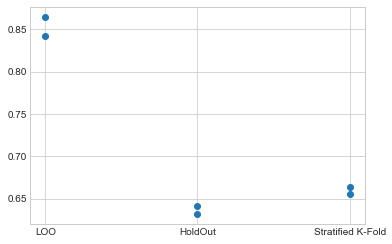

In [21]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','method','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y, test_size = 0.3, random_state = 6,stratify=default_groups)
    holdout = compute_Linear_Regression(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y,groups=default_groups)
    loo = compute_Linear_Regression(testX_data=trainX_data,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited)  
    loo.append('LOO')
    loo.append(scannedType)
    results.append(loo)
    holdout.append('HoldOut')
    holdout.append(scannedType)
    results.append(holdout)
    skf = StratifiedKFold(n_splits=selected_fold)
    splited = skf.split(trainX_data,default_groups,groups=default_groups)
    skfold = compute_Linear_Regression(testX_data=trainX_data,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited)
    skfold.append('Stratified K-Fold')
    skfold.append(scannedType)
    results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['method'],statistics['mae'],'o')
selected_method = statistics.sort_values(by=['mae'])['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

#### 10th Experiment - Best preprocessing technique
Experiment with the different preprocessing techniques

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,preprocessing,preprocessingFunc,type
4,0.631257,0.599754,0.774438,0.777079,-0.523961,0.004485,0.425132,1.210213,-1.510207,1.665629,0.632272,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Rolling Mean RSSI
6,0.631257,0.599754,0.774438,0.777079,-0.523961,0.004485,0.425132,1.210213,-1.510207,1.665629,0.632272,MaxAbsScaler,MaxAbsScaler(copy=True),Rolling Mean RSSI
5,0.631257,0.599754,0.774438,0.777079,-0.523961,0.004485,0.425132,1.210213,-1.510207,1.665629,0.632272,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",Rolling Mean RSSI
7,0.631257,0.599754,0.774438,0.777079,-0.523961,0.004485,0.425132,1.210213,-1.510207,1.665629,0.632272,None,None,Rolling Mean RSSI
0,0.641201,0.599235,0.774103,0.776519,-0.468001,0.085481,0.472646,1.200188,-1.518797,1.689760,0.632590,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",RSSI Only
3,0.641201,0.599235,0.774103,0.776519,-0.468001,0.085481,0.472646,1.200188,-1.518797,1.689760,0.632590,None,None,RSSI Only
1,0.641201,0.599235,0.774103,0.776519,-0.468001,0.085481,0.472646,1.200188,-1.518797,1.689760,0.632590,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",RSSI Only
2,0.641201,0.599235,0.774103,0.776519,-0.468001,0.085481,0.472646,1.200188,-1.518797,1.689760,0.632590,MaxAbsScaler,MaxAbsScaler(copy=True),RSSI Only


Selected Preprocessing:  StandardScaler


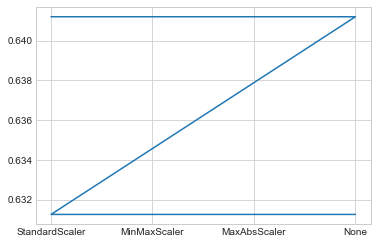

In [22]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','preprocessing','preprocessingFunc','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for preprocess in scaler:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y,groups=default_groups)
            result = compute_Linear_Regression(testX_data=trainX_data,testY_data=train_Y,scaler=preprocess,cross_validation = splited)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups,groups=default_groups)
            result = compute_Linear_Regression(testX_data=trainX_data,testY_data=train_Y,scaler=preprocess,cross_validation = splited)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y, test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_Linear_Regression(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=preprocess)
        if(preprocess is None):
            regex = 'None'
        else:
            regex = re.search('(\w+)\(',str(preprocess)).group(1)
        result.append(regex)
        result.append(preprocess)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['preprocessing'],statistics['mae'])
selected_preprocessing = statistics.sort_values(by=['mae'])['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['mae'])['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

### Best Parameters
Display the best parameters tunned throughout the experiments

In [23]:
conclusion_cols=['Cross Validation','Preprocessing']
conclusion_list = [selected_method,selected_preprocessing]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)

,Cross Validation,Preprocessing
0,HoldOut,StandardScaler


### Best Results
Compute Linear Regression with the best parameters in both RSSI and Rolling Mean

,Actual,Predicted
0,1.5,2.794038
1,2.0,1.855531
2,1.5,2.168367
3,3.0,2.585481
4,0.0,-0.230040
...,...,...
134,3.0,3.211153
135,3.0,2.585481
136,2.5,2.898317
137,0.5,0.917024


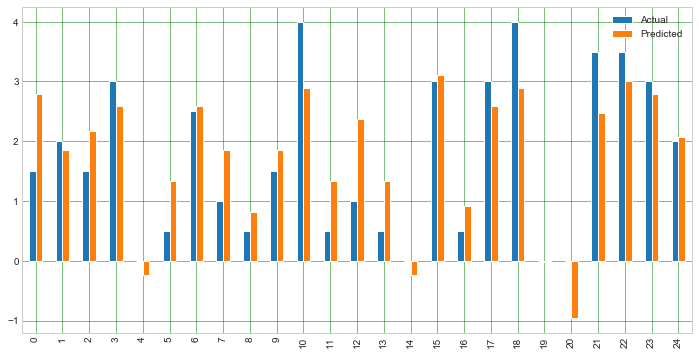

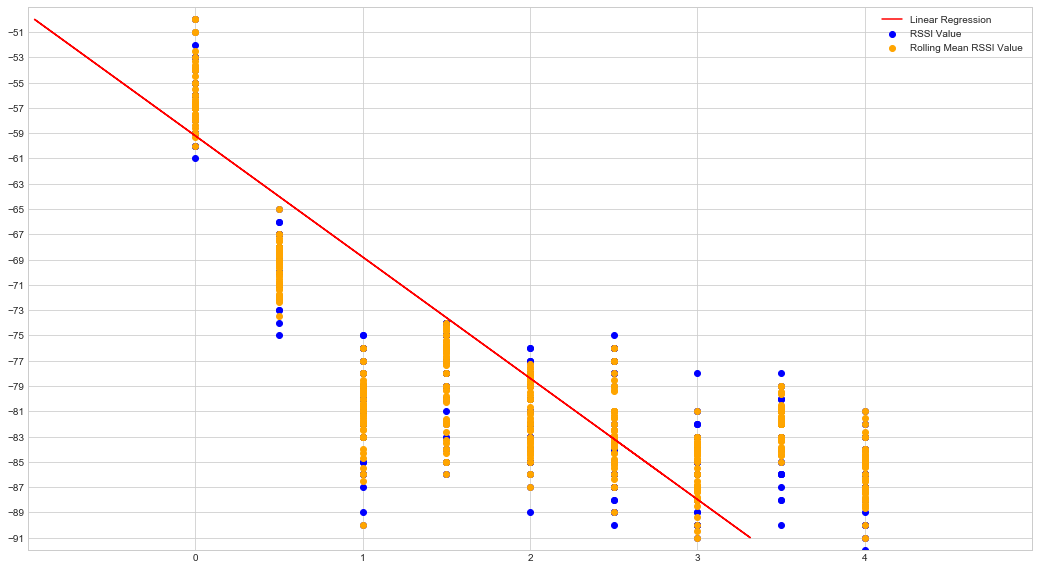

,Actual,Predicted
0,1.5,2.806298
1,2.0,1.962285
2,1.5,2.173288
3,3.0,2.674421
4,0.0,-0.253250
...,...,...
134,3.0,3.017301
135,3.0,2.524960
136,2.5,2.489793
137,0.5,0.907268


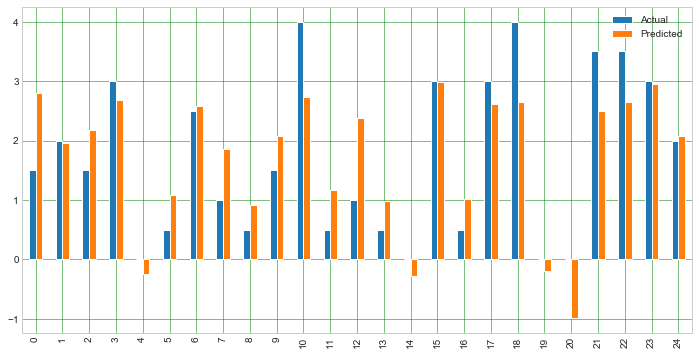

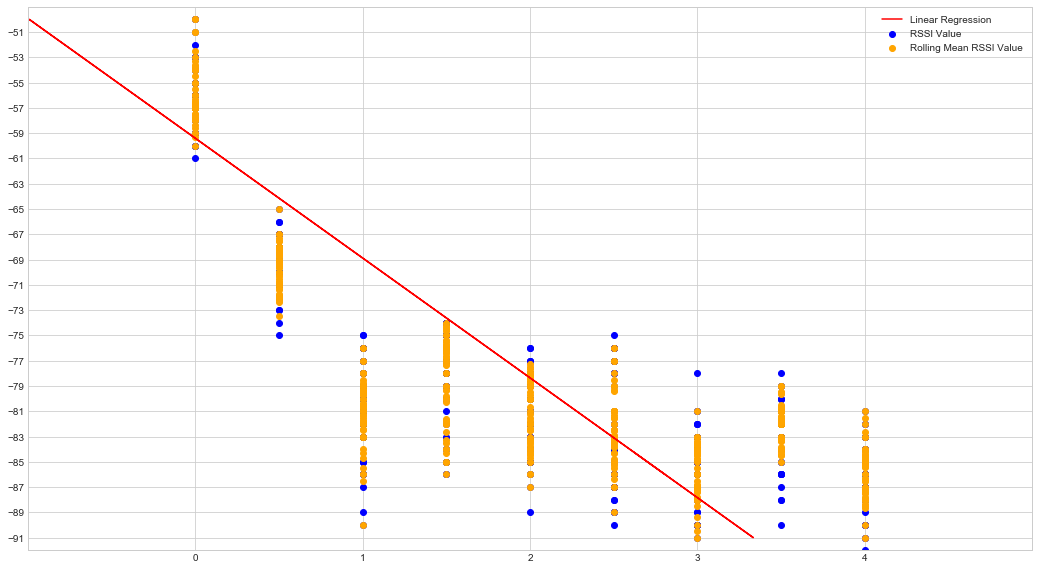

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,type
1,0.631257,0.599754,0.774438,0.777079,-0.523961,0.004485,0.425132,1.210213,-1.510207,1.665629,0.632272,Rolling Mean RSSI
0,0.641201,0.599235,0.774103,0.776519,-0.468001,0.085481,0.472646,1.200188,-1.518797,1.689760,0.632590,RSSI Only


In [24]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(trainX_data,train_Y,groups=default_groups)
        result = compute_Linear_Regression(flag = 1,testX_data=trainX_data,testY_data=train_Y,scaler=selected_preprocesssing_func,cross_validation = splited)  
    elif selected_method =='Stratified K-Fold':
        skf = StratifiedKFold(n_splits=selected_fold)
        splited = skf.split(trainX_data,default_groups,groups=default_groups)
        result = compute_Linear_Regression(flag = 1,testX_data=trainX_data,testY_data=train_Y,scaler=selected_preprocesssing_func,cross_validation = splited)
    else:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y, test_size = 0.3, random_state = 6,stratify=default_groups)
        result = compute_Linear_Regression(flag = 1,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=preprocess)
    result.append(scannedType)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
statistical_cols_csv = ['mae','mse','rmse']
statistical_cols_csv.append('Experimentation')
result_csv = result[0:3]
result_csv.append('Linear Regression')
results_csv = [result_csv]
results_df = pd.DataFrame(columns=statistical_cols_csv,data=results_csv)
results_df.to_csv('../proximity_results.csv',mode='a',index=False,header=False)

### Best Results - Testing data being 1000 plot points
Experiment with testing data of 1000 plot points

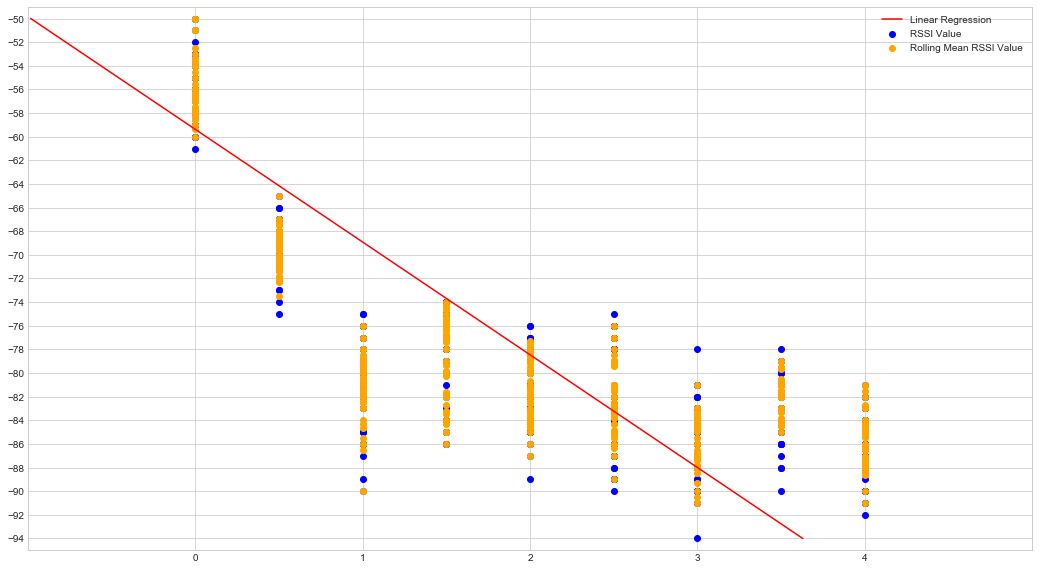

In [25]:
testX_data = np.linspace(dataset['rssi_Value'].min(), dataset['rssi_Value'].max(), 1000).reshape(-1,1)
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
linear_regression_estimator = LinearRegression()
main_estimator = make_pipeline(StandardScaler(),linear_regression_estimator)
main_estimator.fit(train_X_rssi,train_Y)
predict_test = main_estimator.predict(testX_data)
plt.show()
plt.figure(figsize=(18,10))
plt.scatter(dataset['distance'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['distance'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.xlim(train_Y.min()-1, train_Y.max()+1)
plt.ylim(train_X_rssi.min()-1, train_X_rssi.max()+1)
plt.xticks(np.arange(train_Y.min(), train_Y.max()+1, 1.0))
plt.yticks(np.arange(train_X_rssi.min(), train_X_rssi.max()+1, 2.0))
plt.plot(predict_test, testX_data, color='red', label='Linear Regression')
# Show and place the legent
plt.legend(loc='upper right')
plt.show()